# Install & Import

In [1]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [2]:
from catboost.datasets import adult, rotten_tomatoes
from datasets import load_dataset
from graphviz import Digraph
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Utils

In [3]:
def get_dataset(dataset_name):
    if dataset_name == "credit_card":
        df = pd.DataFrame(load_dataset("imodels/credit-card")["train"])
        df_train, df_test = train_test_split(df, test_size=.5)
        out = {
            "df_train": df_train,
            "df_test": df_test,
            "task": "classification",
            "target_column": "default.payment.next.month",
            "num_features": [
                "limit_bal",
                "age",
                "pay_0",
                "pay_2",
                "pay_3",
                "pay_4",
                "pay_5",
                "pay_6",
                "bill_amt1",
                "bill_amt2",
                "bill_amt3",
                "bill_amt4",
                "bill_amt5",
                "bill_amt6",
                "pay_amt1",
                "pay_amt2",
                "pay_amt3",
                "pay_amt4",
                "pay_amt5",
                "pay_amt6",
                "sex:1",
                "sex:2",
                "education:0",
                "education:1",
                "education:2",
                "education:3",
                "education:4",
                "education:5",
                "education:6",
                "marriage:0",
                "marriage:1",
                "marriage:2",
                "marriage:3",
            ],
            "cat_features": [],
            "text_features": [],
        }

    if dataset_name == "adult":
        df, _ = adult()
        df["income"] = df["income"] == ">50K"
        df_train, df_test = train_test_split(df, test_size=.5)
        out = {
            "df_train": df_train,
            "df_test": df_test,
            "task": "classification",
            "target_column": "income",
            "num_features": ["age", "fnlwgt", "hours-per-week"],
            "cat_features": [
                "workclass", "education", "occupation", "marital-status", "relationship",
                "race", "sex", "native-country",
            ],
            "text_features": [],
        }

    if dataset_name == "rotten_tomatoes":
        df_train, df_test = rotten_tomatoes()
        df_train = df_train[~df_train["box_office"].isna()]
        df_test = df_test[~df_test["box_office"].isna()]
        out = {
            "df_train": df_train,
            "df_test": df_test,
            "task": "regression",
            "target_column": "box_office",
            "num_features": ["runtime"],
            "cat_features": ["rating_MPAA", "studio"],
            "text_features": ["synopsis"],
        }
    return out

In [4]:
def preprocess_data(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    target_column: str,
    num_features: list = [],
    cat_features: list = [],
    text_features: list = [],
):
    X_train = df_train[cat_features + num_features + text_features]
    X_test = df_test[cat_features + num_features + text_features]
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    transformers = []
    if cat_features:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_features))
    if num_features:
        transformers.append(("num", SimpleImputer(strategy="mean"), num_features))
    if text_features:
        for text_feature in text_features:
            transformers.append(
                (
                    f"txt_{text_feature}",
                    make_pipeline(
                        FunctionTransformer(lambda x: x.to_frame(), validate=False),
                        SimpleImputer(strategy="constant", fill_value=""),
                        FunctionTransformer(lambda x: x.ravel(), validate=False),
                        TfidfVectorizer(max_features=1_000),
                    ),
                    text_feature,
                )
            )

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="drop"
    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, y_train, X_test, y_test, preprocessor

In [5]:
def get_model_names(task):
    if task == "classification":
        return [
            "DecisionTreeClassifier(max_depth=1)",
            "DecisionTreeClassifier(max_depth=2)",
            "DecisionTreeClassifier(max_depth=3)",
            "LogisticRegression()",
            "XGBClassifier()",
        ]
    elif task == "regression":
        return [
            "DecisionTreeRegressor(max_depth=1)",
            "DecisionTreeRegressor(max_depth=2)",
            "DecisionTreeRegressor(max_depth=3)",
            "LinearRegression()",
            "XGBRegressor()",
        ]

In [6]:
def count_model_parameters(model):
    if type(model) in [XGBClassifier, XGBRegressor]:
        leaf_count = 0
        for tree in model.get_booster().get_dump():
            leaf_count += sum(1 for line in tree.split('\n') if 'leaf=' in line)
        return leaf_count
    elif type(model) == LinearRegression:
        return len(model.coef_) + 1
    elif type(model) == LogisticRegression:
        return len(model.coef_[0]) + 1
    elif type(model) in [DecisionTreeClassifier, DecisionTreeRegressor]:
        n_leaves = sum(
            (model.tree_.children_left == -1) & (model.tree_.children_right == -1)
        )
        return n_leaves

In [7]:
def count_features_used(model):
    if type(model) in [XGBClassifier, XGBRegressor]:
        booster = model.get_booster()
        return len(booster.get_score(importance_type="weight"))
    elif type(model) == LinearRegression:
        return len(model.coef_[model.coef_ != 0])
    elif type(model) == LogisticRegression:
        return len(model.coef_[0][model.coef_[0] != 0])
    elif type(model) in [DecisionTreeClassifier, DecisionTreeRegressor]:
        return len(set(model.tree_.feature[model.tree_.feature >= 0]))

In [8]:
def draw_decision_tree(
    tree_model,
    feature_names,
    filename="tree",
):

    tree_ = tree_model.tree_
    dot = Digraph(format="png")
    dot.attr(dpi="200")

    is_classifier = hasattr(tree_model, "classes_")

    def recurse(node, path_rules):
        label = "All" if node == 0 else "\n".join(path_rules) if path_rules else "All"

        if tree_.feature[node] != -2:  # Not a leaf
            dot.node(str(node), label, fontname="Arial", fontsize="12")
            # Left child (feature < threshold)
            left_rule = f"{feature_names[tree_.feature[node]]} < {tree_.threshold[node]:.1f}"
            recurse(tree_.children_left[node], path_rules + [left_rule])
            dot.edge(str(node), str(tree_.children_left[node])) #, left_rule)

            # Right child (feature >= threshold)
            right_rule = f"{feature_names[tree_.feature[node]]} ≥ {tree_.threshold[node]:.1f}"
            recurse(tree_.children_right[node], path_rules + [right_rule])
            dot.edge(str(node), str(tree_.children_right[node])) #, right_rule)
        else:
            # Leaf node
            value = tree_.value[node][0]
            if is_classifier:
                prob = value[1] / value.sum()
                pred_str = f"Pred: {prob:.1%}"
            else:
                pred_str = f"Pred: {value[0]:.1f}" if len(value) == 1 else "Preds:\n" + ", ".join(f"{v:.1f}" for v in value)
            leaf_label = f"{label}\n\n{pred_str}"
            dot.node(str(node), leaf_label, shape='box', style='filled', fillcolor='lightgrey', fontname="Arial", fontsize="12")

    recurse(0, [])
    dot.render(filename=filename, cleanup=True)

    return dot

# Run models

In [9]:
results = pd.DataFrame()
enum = 0

for dataset_name in ["credit_card", "adult"]:

    dataset = get_dataset(dataset_name)
    task = dataset["task"]

    X_train, y_train, X_test, y_test, preprocessor = preprocess_data(
        df_train=dataset["df_train"],
        df_test=dataset["df_test"],
        target_column=dataset["target_column"],
        num_features=dataset["num_features"],
        cat_features=dataset["cat_features"],
        text_features=dataset["text_features"],
    )

    for model_name in get_model_names(task=task):

        model = eval(model_name).fit(X_train, y_train)

        if task == "classification":
            prediction_test = model.predict_proba(X_test)[:,1]
        elif task == "regression":
            prediction_test = model.predict(X_test)

        results.loc[enum, "dataset"] = dataset_name
        results.loc[enum, "n_features"] = X_train.shape[1]
        results.loc[enum, "model"] = model_name
        results.loc[enum, "n_parameters"] = count_model_parameters(model)
        #results.loc[enum, "n_features_used"] = count_features_used(model)

        if task == "classification":
            results.loc[enum, "roc_auc_test"] = roc_auc_score(y_test, prediction_test)
        elif task == "regression":
            results.loc[enum, "r2_test"] = r2_score(y_test, prediction_test)

        enum += 1

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/24000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [10]:
results_display = results.copy()

for feature in ["n_features", "n_parameters"]:
    results_display[feature] = results_display[feature].apply(lambda x: f"{x:,.0f}")

for feature in ["roc_auc_test", "r2_test"]:
    if feature in results_display.columns:
        results_display[feature] = results_display[feature].apply(lambda x: f"{x:.1%}" if not np.isnan(x) else "")

# Display results

In [11]:
for dataset_name in ["credit_card", "adult"]:
    results_display_sub = results_display[results_display["dataset"]==dataset_name].reset_index(drop=True)
    cols_drop = results_display_sub.columns[results_display_sub.map(lambda x: len(str(x))).min() == 0]
    display(results_display_sub.drop(cols_drop, axis=1))
    print()

,dataset,n_features,model,n_parameters,roc_auc_test
0,credit_card,33,DecisionTreeClassifier(max_depth=1),2,65.3%
1,credit_card,33,DecisionTreeClassifier(max_depth=2),4,70.3%
2,credit_card,33,DecisionTreeClassifier(max_depth=3),8,73.7%
3,credit_card,33,LogisticRegression(),34,65.2%
4,credit_card,33,XGBClassifier(),"3,989",76.0%


,dataset,n_features,model,n_parameters,roc_auc_test
0,adult,105,DecisionTreeClassifier(max_depth=1),2,75.7%
1,adult,105,DecisionTreeClassifier(max_depth=2),4,79.5%
2,adult,105,DecisionTreeClassifier(max_depth=3),8,82.6%
3,adult,105,LogisticRegression(),106,83.5%
4,adult,105,XGBClassifier(),"3,214",88.5%


In [12]:
dataset = get_dataset("credit_card")

X_train, y_train, X_test, y_test, preprocessor = preprocess_data(
    df_train=dataset["df_train"],
    df_test=dataset["df_test"],
    target_column=dataset["target_column"],
    num_features=dataset["num_features"],
    cat_features=dataset["cat_features"],
    text_features=dataset["text_features"],
)

In [13]:
model = LogisticRegression().fit(X_train, y_train)

pd.Series(
    list(model.intercept_)+list(model.coef_[0]),
    index=["intercept_"]+list(preprocessor.get_feature_names_out()),
).rename("Coefficient").to_frame()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Coefficient
intercept_,-2.493492e-05
num__limit_bal,-5.234397e-06
num__age,-7.650572e-04
num__pay_0,5.601088e-05
num__pay_2,4.244626e-05
num__pay_3,4.082224e-05
num__pay_4,3.774640e-05
num__pay_5,3.695209e-05
num__pay_6,3.617116e-05
num__bill_amt1,-6.643364e-06


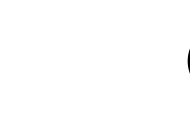

In [14]:
model = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)

draw_decision_tree(
    tree_model=model,
    feature_names=[c.replace("num__", "") for c in preprocessor.get_feature_names_out()],
    filename="graph_max_depth_1",
)

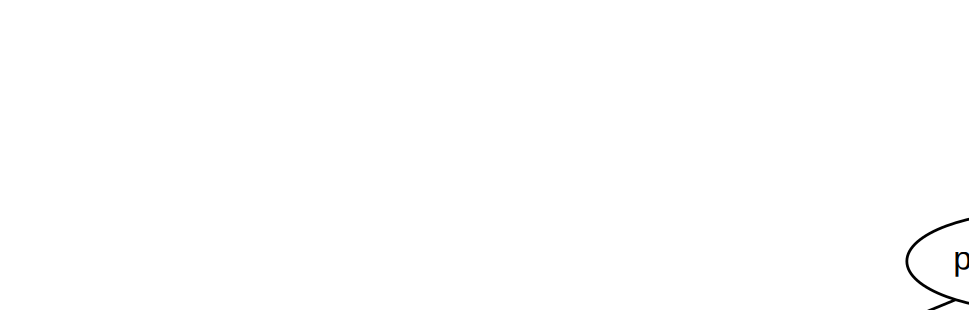

In [15]:
model = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

draw_decision_tree(
    tree_model=model,
    feature_names=[c.replace("num__", "") for c in preprocessor.get_feature_names_out()],
    filename="graph_max_depth_3",
)